# Apprendimento supervisionato

In [1]:
import sys
import asyncio

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

# Read the CSV file
original_df = pd.read_csv('used_cars.csv')


def preprocessing(df):
    df = df.copy()
    # Per non avere valori nulli nella colonna Service History
    df['Service history'] = df['Service history'].fillna("Unavailable")
    df['Service history'] = df['Service history'].map({'Full': True, 'Unavailable': False})
    # Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
    # In python gli alberi di decisione non supportano feature categoriche

    # Prendere solo la marca dell'auto
    df['title'] = df['title'].apply(lambda x: x.split()[0] if isinstance(x, str) else x)

    # Eliminare la prima colonna che è l'indice
    df = df.drop(df.columns[0], axis=1)

    # Prendi la cilindrata dell'auto e trasformala in un numero
    df['Engine'] = df['Engine'].str.replace('L', '').astype(float)

    df['Gearbox'] = df['Gearbox'].map({'Automatic': True, 'Manual': False})
    df = df.rename(columns={'Gearbox': 'Gearbox Automatic'})

    df['Emission Class'] = pd.to_numeric(df['Emission Class'].str.replace('Euro ', ''), errors='coerce')

    df = pd.get_dummies(df, columns=['Fuel type', 'Body type', 'title'])

    # Algoritmi necessitano di valori non nulli
    df = df.dropna()

    return df


def calculate_baseline_score(df, target_column, scoring):
    # Per vedere se la loss del modello è migliore di quella che si potrebbe ottenere con una predizione banale, come media o mediana
    if scoring == "neg_root_mean_squared_error":
        # Per loss quadratiche si usa la media
        baseline_prediction = df[target_column].mean()
        baseline_error = - (df[target_column] - baseline_prediction).pow(2).mean() ** 0.5
    elif scoring == "neg_mean_squared_error":
        baseline_prediction = df[target_column].mean()
        baseline_error = - (df[target_column] - baseline_prediction).pow(2).sum().mean()
    elif scoring == "neg_mean_absolute_error":
        # Per loss assolute si usa la mediana
        baseline_prediction = df[target_column].median()
        baseline_error = - (df[target_column] - baseline_prediction).abs().mean()
    else:
        raise ValueError("Invalid scoring metric")

    return baseline_error


def train_model(model, param_grid, X, y, cv, scoring):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)

    # scores = cross_val_score(ctf, X, y, cv=cv, scoring=scoring)
    # grid_search.fit implicitamente usa cross_val_score e quindi non abbiamo bisogno di ripeterlo
    # Gli score ottenuti usando cross_val_score con i migliori iperparametri sono già restituiti da grid_search
    scores = grid_search.best_score_
    params = grid_search.best_params_
    print("Scores:", scores)
    print("Best params:", params)

    model_results = {"scores": scores, "params": params}

    return model_results


## Training dei modelli

In [13]:
target_column = "Price"
# Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
# In python gli alberi di decisione non supportano feature categoriche
preprocessed_df = preprocessing(original_df)

tries = {}

print(preprocessed_df)

X = preprocessed_df.drop(target_column, axis=1)
y = preprocessed_df[target_column]

# Scelte due metriche di scoring
scorings = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']

results = {s: {"decision_tree": {"scores": None, "params": None},
            "random_forest": {"scores": None, "params": None},
            "gradient_boosted_trees": {"scores": None, "params": None}} for s in scorings }

dtr_param_grid = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    # 'splitter': ['best'],
    # 'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

rfr_param_grid = {
    'n_estimators': [100, 200],
    # 'criterion': ["squared_error", "friedman_mse", "poisson"],  # "absolute_error" è troppo lento
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

# Best params: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}

gbr_param_grid = {
    'n_estimators': [100, 200],
    # 'loss': ['squared_error', 'huber', 'quantile'],   # "absolute_error" è troppo lento
    # 'learning_rate': [0.01, 0.1, 0.5],
    # 'criterion': ['friedman_mse', 'squared_error'],
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10, 20],
    # 'min_samples_leaf': [1, 2, 5],
}

# Perform 5-fold cross-validation, repeated 3 times, and print the average score
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
# TODO fonty per la grid search fa solo cv=5 che come se fosse n_repeats=1

# Addestrare ogni modello per ogni metrica di scoring
for scoring in scorings:
    baseline_score = calculate_baseline_score(original_df, target_column, scoring)
    print(f"Baseline for scoring metric {scoring}: ", baseline_score)

    dtc = DecisionTreeRegressor(random_state=42)
    print(f"Training decision tree with scoring metric {scoring}")
    results[scoring]["decision_tree"] = train_model(dtc, dtr_param_grid, X, y, cv, scoring)
    tries[f"Learning Curve (Decision Tree, {scoring})"] = [dtc, scoring, cv]

    rfc = RandomForestRegressor(random_state=42)
    print(f"Training random forest with scoring metric {scoring}")
    results[scoring]["random_forest"] = train_model(rfc, rfr_param_grid, X, y, cv, scoring)
    tries[f"Learning Curve (Random Forest, {scoring})"] = [rfc, scoring, cv]

    gbt = GradientBoostingRegressor(random_state=42)
    print(f"Training gradient boosted model with scoring metric {scoring}")
    results[scoring]["gradient_boosted_trees"] = train_model(gbt, gbr_param_grid, X, y, cv, scoring)
    tries[f"Learning Curve (Gradient Boosted Trees, {scoring})"] = [gbt, scoring, cv]

print(results)


      Price  Mileage(miles)  Registration_Year  Previous Owners  Engine  \
0      6900           70189               2016              3.0     1.4   
1      1495           88585               2008              4.0     1.2   
3      2395           96731               2010              5.0     1.4   
5       800          124196               2007              3.0     2.0   
9      1299           87000               2008              5.0     1.6   
...     ...             ...                ...              ...     ...   
3676   2750          100000               2004              3.0     3.7   
3677   2475          156097               1998              2.0     2.2   
3679   1695          104000               2009              3.0     1.6   
3680   1395           76202               2006              4.0     1.6   
3684   2000           82160               2013              7.0     1.2   

      Gearbox Automatic  Doors  Seats  Emission Class  Service history  ...  \
0                 Fa

## Performance Comparison

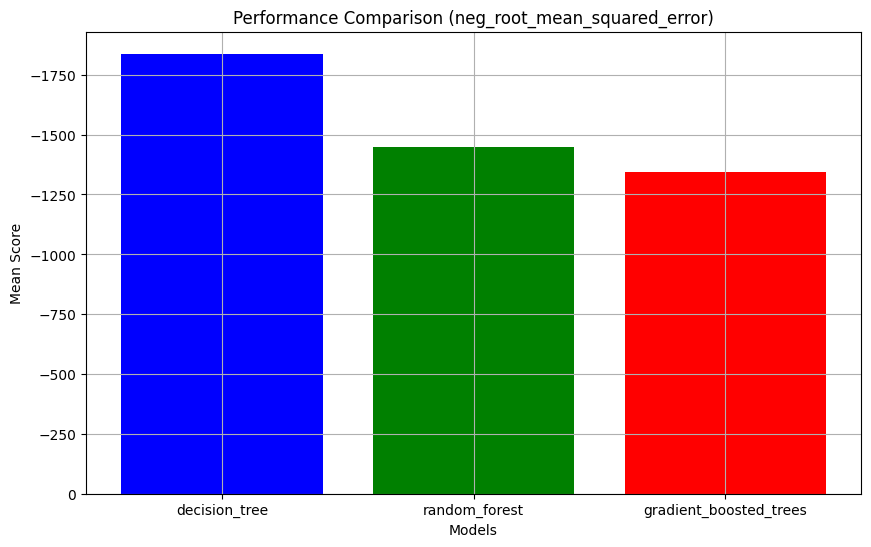

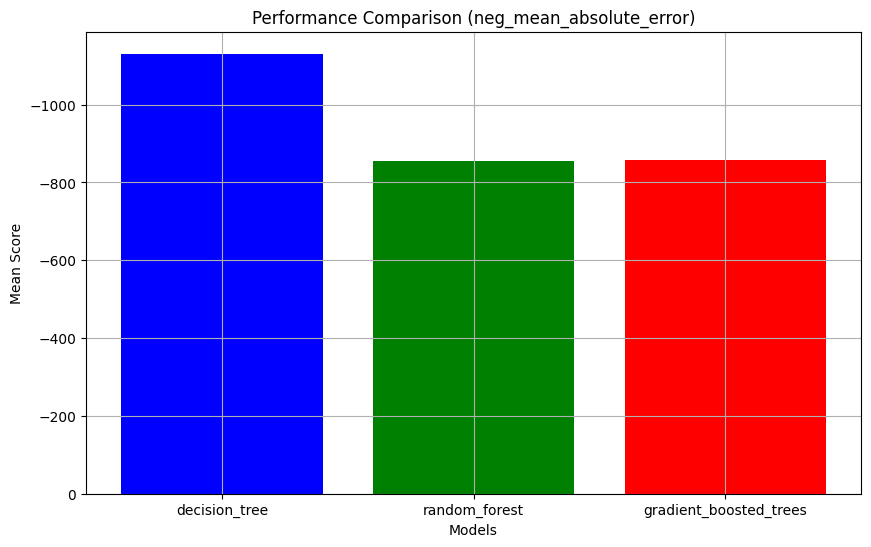

In [37]:
for scoring in scorings:
    fig, ax = plt.subplots(figsize=(10, 6))

    models = ['decision_tree', 'random_forest', 'gradient_boosted_trees']
    scores = [results[scoring][model]["scores"] for model in models]

    # Extract mean scores for plotting
    mean_scores = [np.mean(score) for score in scores]

    ax.bar(models, mean_scores, color=['blue', 'green', 'red'])
    plt.gca().invert_yaxis()

    ax.set_title(f'Performance Comparison ({scoring})')
    ax.set_xlabel('Models')
    ax.set_ylabel('Mean Score')

    # Adjust y-axis limits to better visualize negative scores
    # ymin = max(mean_scores) * 1.1 if min(mean_scores) < 0 else max(mean_scores) * 0.9
    # ymax = min(mean_scores) * 1.1 if max(mean_scores) > 0 else min(mean_scores) * 0.9
    # ax.set_ylim([ymin, ymax])
    ax.grid(True)

    # Adding text for each bar
    # for i, v in enumerate(mean_scores):
    #     if v < 0:
    #         ax.text(i, v - (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='top')
    #     else:
    #         ax.text(i, v + (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='bottom')

    plt.savefig(f"performance_comparison_{scoring}.png")


## Learning Curve

In [43]:
import pandas as pd

# Initialize an empty DataFrame
variance_df = pd.DataFrame(columns=['Model', 'Train Score Variance', 'Test Score Variance'])

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

for title in list(tries.keys())[0:1]:
    estimator = tries[title][0]
    scoring = tries[title][1]

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10), scoring=scoring
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig(f"{title}.png")
    print(f"Saved {title}.png")

    # Calculate the variance of the train and test scores
    train_score_variance = np.var(train_scores, axis=1).mean()
    test_score_variance = np.var(test_scores, axis=1).mean()
    
    # Create a DataFrame with a single row of data
    variance_data = pd.DataFrame([{
        'Model': title,
        'Train Score Variance': train_score_variance,
        'Test Score Variance': test_score_variance
    }])

    # Append the new data to the DataFrame
    variance_df = pd.concat([variance_df, variance_data], ignore_index=True)
# Print the DataFrame
print(variance_df)

KeyboardInterrupt: 

# Apprendimento non supervisionato

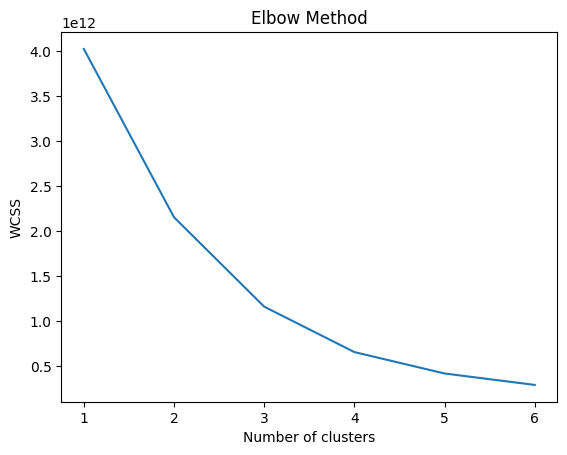

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calcola la somma dei quadrati interni per diversi numeri di cluster
wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Crea un grafico con il numero di cluster sull'asse x e WCSS sull'asse y
plt.plot(range(1, 7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Somma delle distanze quadrate interne')
plt.show()


In [46]:
n_clusters = 3 # o 4???

kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Addestra il modello sui dati
kmeans.fit(X)

# Utilizza il modello per fare previsioni
predictions = kmeans.predict(X)

# Aggiungi le previsioni al DataFrame
preprocessed_df['Cluster'] = predictions

...

KeyboardInterrupt: 